In [60]:
import os
import time
from collections import OrderedDict
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from PIL import Image

from

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms.functional import to_tensor

from nltk.tokenize import word_tokenize, RegexpTokenizer

import wandb

# set WANDB_NOTEBOOK_NAME 
os.environ['WANDB_NOTEBOOK_NAME'] = 'mc2.ipynb'


In [10]:
config = dict(
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    image_dir = 'flickr8k/images',
    caption_file = 'flickr8k/captions.txt',
)

config

{'epochs': 10,
 'batch_size': 32,
 'learning_rate': 0.001,
 'device': device(type='cuda', index=0),
 'image_dir': 'flickr8k/images',
 'caption_file': 'flickr8k/captions.txt'}

In [109]:
class Vocab():

    def __init__(self, captions_file, tokenizer):
        self.tokenizer = tokenizer
        self.captions_file = captions_file
        self.build_vocab()

    def build_vocab(self):
        vocab = OrderedDict()

        # Add special tokens
        vocab['<pad>'] = None
        vocab['<sos>'] = None
        vocab['<eos>'] = None

        captions = pd.read_csv(config["caption_file"], delimiter='|')['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)
        
        for caption in captions:
            for token in self.tokenizer(caption):
                if token not in vocab:
                    vocab[token] = None

        self.idx2word = list(vocab.keys())
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}

        self.pad_idx = self.word2idx['<pad>']
        self.sos_idx = self.word2idx['<sos>']
        self.eos_idx = self.word2idx['<eos>']

    def __len__(self):
        return len(self.idx2word)

    def token_to_idx(self, token):
        return self.word2idx[token]

    def idx_to_token(self, idx):
        return self.idx2word[idx]


special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens

vocab = Vocab(config["caption_file"], tokenizer=special_word_tokenizer.tokenize)

config['vocab_size'] = len(vocab)

print(f'Vocab size: {config["vocab_size"]}')

Vocab size: 8831


In [95]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, tokenizer, word2idx, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the txt file with captions.
            transform (callable, optional): Optional transform to be applied
                on a image sample.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, delimiter='|')
        self.transform = transform
        self.tokenizer = tokenizer
        self.word2idx = word2idx

        # clean caption_text
        self.df['caption_text'] = self.df['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', " ", regex=True)
        # append <start> and <end> to caption_text
        self.df['caption_text'] = self.df['caption_text'].apply(lambda x: '<sos> ' + x + ' <eos>') \
                                                         .apply(lambda x: torch.LongTensor(self._caption_to_idx(x)))
        # store memory
        self.captions_image_names = list(zip(self.df['caption_text'], self.df['image_name']))
        
        self.images = {}

        # load all images into memory
        for img_name in tqdm(self.df['image_name'].unique()):
            img_path = os.path.join(self.root_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)

            self.images[img_name] = image

    def _caption_to_idx(self, caption):
        return [self.word2idx[word] for word in self.tokenizer(caption)]
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption, img_name = self.captions_image_names[idx]
        image = self.images[img_name]
        return image, caption


dataset = Flickr8kDataset(config["image_dir"],
                          config["caption_file"],
                          special_word_tokenizer.tokenize,
                          word2idx,
                          models.ResNet50_Weights.IMAGENET1K_V1.transforms())
print(len(dataset))

100%|██████████| 8091/8091 [01:34<00:00, 85.48it/s] 


40455


In [87]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images)
        captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


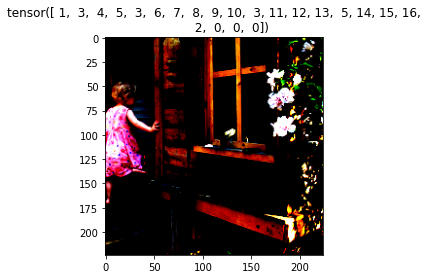

In [96]:
test_loader = DataLoader(dataset,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(config["pad_idx"]))
for i, (images, captions) in enumerate(test_loader):

    plt.imshow(images[0].permute(1, 2, 0))
    plt.title(captions[0])
    plt.show()
    break

In [33]:
# analyze the captions lengths
lengths = []
total_data_loader_len = len(test_loader)
for i, (images, captions) in tqdm(enumerate(test_loader), total=total_data_loader_len):
    lengths.append(np.array(captions.shape[1] - (captions == config['pad_idx']).sum(dim=1)))

100%|██████████| 1265/1265 [01:20<00:00, 15.75it/s]


In [40]:
# convert lengths to numpy array
np.concatenate(lengths).shape

(40455,)

Captions lengths shape: (40455,)


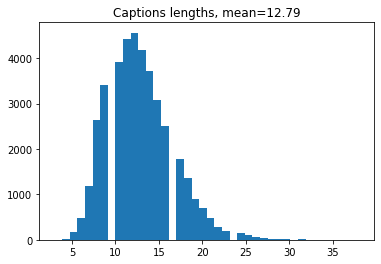

In [42]:
lengths_arr = np.concatenate(lengths)

print("Captions lengths shape:", lengths_arr.shape)

plt.hist(lengths_arr, bins=40)
plt.title("Captions lengths, mean={:.2f}".format(lengths_arr.mean()))
plt.show()


# Model

In [110]:
class Encoder(nn.Module):

    def __init__(self, image_embedding_dim: int):
        super(Encoder, self).__init__()
        self.image_embedding_dim = image_embedding_dim

        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        self.fc = nn.Linear(resnet.fc.in_features, self.image_embedding_dim)


    def forward(self, images: torch.Tensor) -> torch.Tensor:
        x = self.resnet(images)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
    

class Decoder(nn.Module):

    def __init__(self, embedding_dim: int, lstm_layers: int, vocabulary_size: int, max_sequence_length: int, padding_idx: int, start_of_sequence_idx: int, end_of_sequence_idx: int):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.lstm_layers = lstm_layers
        self.vocabulary_size = vocabulary_size
        self.max_sequence_length = max_sequence_length
        self.padding_idx = padding_idx
        self.start_of_sequence_idx = start_of_sequence_idx
        self.end_of_sequence_idx = end_of_sequence_idx
        
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dim, padding_idx=padding_idx)

        self.hidden_state_0 = nn.Parameter(torch.zeros((self.lstm_layers, 1, embedding_dim)))
        self.cell_state_0 = nn.Parameter(torch.zeros((self.lstm_layers, 1, embedding_dim)))


        self.lstm = nn.LSTM(input_size = embedding_dim,
                            hidden_size = embedding_dim,
                            num_layers = self.lstm_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, self.vocabulary_size),
            nn.LogSoftmax(dim=1)
        )

    def embed_sequence(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.embedding_layer(sequence)

    def forward(self, image_embedding: torch.Tensor, captions: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        captions = self.embedding_layer(captions).permute(1, 0, 2)

        embeddings = torch.cat((image_embedding, captions), dim=0)
                
        outputs, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc(outputs)
        
        return outputs, (hidden, cell)

image_encoder = Encoder(512)
caption_decoder = Decoder(512, 1, len(vocab), 40, vocab.pad_idx, vocab.sos_idx, vocab.eos_idx)

image_encoder.to(config["device"])
caption_decoder.to(config["device"])

image_encoder.train()
caption_decoder.train()

# create random tensor of images and captions 
images = torch.randn(32, 3, 500, 500).to(config["device"])
# sequence of 40 words
captions = torch.randint(0, len(vocab), (32, 40)).to(config["device"])
# convert to embeddings
print("captions:", captions.size())

# encode images
image_features = image_encoder(images).unsqueeze(0)
print("image_features:", image_features.size())

# initialize hidden and cell states
hidden = caption_decoder.hidden_state_0.repeat(1, 32, 1)
cell = caption_decoder.cell_state_0.repeat(1, 32, 1)



print("hidden:", hidden.size())
print("cell:", cell.size())

# decode
outputs, (hidden, cell) = caption_decoder(image_features, captions, hidden, cell)

# remove last token from outputs
outputs = outputs[:-1]

print("outputs:", outputs.size())
print("hidden:", hidden.size())
print("cell:", cell.size())

# compute loss
#loss = nn.NLLLoss()(outputs.permute(1, 2, 0), captions.permute(1, 0))
loss = nn.NLLLoss()(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))

print("loss:", loss)

# check if on cuda
print(next(image_encoder.parameters()).is_cuda)
print(next(caption_decoder.parameters()).is_cuda)
print(next(caption_decoder.embedding_layer.parameters()).is_cuda)
print(next(caption_decoder.lstm.parameters()).is_cuda)
print(next(caption_decoder.fc.parameters()).is_cuda)
print(outputs.is_cuda)
print(hidden.is_cuda)
print(cell.is_cuda)


# convert outputs to captions_idx
captions = torch.argmax(outputs, dim=2)
print("captions:", captions.size())

# convert captions_idx to captions
captions = [[idx2word[idx.item()] for idx in caption] for caption in captions]
print("captions:", captions[0])

captions: torch.Size([32, 40])
image_features: torch.Size([1, 32, 512])
hidden: torch.Size([1, 32, 512])
cell: torch.Size([1, 32, 512])
outputs: torch.Size([40, 32, 8831])
hidden: torch.Size([1, 32, 512])
cell: torch.Size([1, 32, 512])
loss: tensor(3.4679, device='cuda:0', grad_fn=<NllLossBackward0>)
True
True
True
True
True
True
True
True
captions: torch.Size([40, 32])
captions: ['razzling', 'tile', 'motley', 'hooping', 'san', 'shirts', '13', 'blondhaired', 'emphatically', 'dinghy', 'outfield', 'rod', 'alotment', 'nations', 'batsman', 'begs', 'beached', 'motion', 'items', 'handing', 'hangong', 'persues', 'busstop', 'exibit', 'ball', 'ship', 'firefighters', 'buffalo', 'not', 'tackling', 'stirs', 'redish']


In [12]:
# visualize the model
from torchviz import make_dot

# print number of parameters
params = list(image_encoder.parameters()) + list(caption_decoder.parameters())
print("Number of parameters:", sum([np.prod(p.size()) for p in params]))

make_dot(outputs, params=dict(list(image_encoder.named_parameters()) + list(caption_decoder.named_parameters()))).render("model", format="png")

Number of parameters: 35711167


'model.png'

In [104]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
print(len(train_dataset), len(val_dataset))

def get_data_loader(dataset: Dataset, config: dict):
    return DataLoader(
        dataset=dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        pin_memory=True,
        collate_fn=Collate(config["pad_idx"])
    )

32364 8091


In [111]:
with wandb.init(project="del-mc2", entity="florin-barbisch", config=config) as run:

    train_loader = get_data_loader(train_dataset, config)
    val_loader = get_data_loader(val_dataset, config)

    # create the model
    image_encoder   = Encoder(512) \
                            .to(config["device"])
    caption_decoder = Decoder(512, 1, len(vocab), 40, vocab.pad_idx, vocab.sos_idx, vocab.eos_idx) \
                            .to(config["device"])
    
    # define the loss function
    loss_function = nn.NLLLoss(ignore_index=config["pad_idx"])

    parameters = list(image_encoder.parameters()) + list(caption_decoder.parameters())

    optimizer = torch.optim.Adam(parameters, lr=config["learning_rate"])

    start_time = time.time()
    # train the model
    for epoch in range(config["epochs"]):
        for i, batch in enumerate(train_loader):
            # set to training mode
            image_encoder.train()
            caption_decoder.train()

            # unpack batch and send to device
            images, captions = batch
            images   = images  .to(config["device"])
            captions = captions.to(config["device"])

            # encode images
            image_features = image_encoder(images).unsqueeze(0)

            # initialize hidden and cell states
            hidden = caption_decoder.hidden_state_0.repeat(1, images.size(0), 1)
            cell = caption_decoder.cell_state_0.repeat(1, images.size(0), 1)

            # decode
            outputs, (hidden, cell) = caption_decoder(image_features, captions, hidden, cell)

            # remove last token from outputs
            outputs = outputs[:-1]

            # calculate loss
            loss = loss_function(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))

            # backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.item()})

            if i % 100 == 0:
                print(f"time: {time.time() - start_time}")
                print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')


time: 0.09020590782165527
Epoch: 0, Batch: 0, Loss: 3.466341257095337
time: 8.979271411895752
Epoch: 0, Batch: 100, Loss: 3.4793732166290283
